In [195]:
#Importing libraries
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib as mpl
from matplotlib import pyplot as plt
from wordcloud import WordCloud
from sklearn.metrics import accuracy_score, log_loss
from sklearn.naive_bayes import GaussianNB
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_validate
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import cross_val_predict
from sklearn.metrics import confusion_matrix
from sklearn.svm import SVC, LinearSVC
from xgboost import XGBClassifier
from sklearn.preprocessing import LabelEncoder
%matplotlib inline

In [196]:
IS_FOR_KAGGLE = True

if IS_FOR_KAGGLE:
    trd = pd.read_csv('../input/titanic/train.csv')
    tsd = pd.read_csv('../input/titanic/test.csv')
else:
    trd = pd.read_csv('train.csv')
    tsd = pd.read_csv('test.csv')

td = pd.concat([trd, tsd], ignore_index=True, sort  = False)

In [197]:
td.shape

(1309, 12)

In [198]:
td.head(5)

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0.0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1.0,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1.0,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1.0,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0.0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


In [199]:
td.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1309 entries, 0 to 1308
Data columns (total 12 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   PassengerId  1309 non-null   int64  
 1   Survived     891 non-null    float64
 2   Pclass       1309 non-null   int64  
 3   Name         1309 non-null   object 
 4   Sex          1309 non-null   object 
 5   Age          1046 non-null   float64
 6   SibSp        1309 non-null   int64  
 7   Parch        1309 non-null   int64  
 8   Ticket       1309 non-null   object 
 9   Fare         1308 non-null   float64
 10  Cabin        295 non-null    object 
 11  Embarked     1307 non-null   object 
dtypes: float64(3), int64(4), object(5)
memory usage: 122.8+ KB


In [200]:
td.isnull().sum()#количество пропущенных значений

PassengerId       0
Survived        418
Pclass            0
Name              0
Sex               0
Age             263
SibSp             0
Parch             0
Ticket            0
Fare              1
Cabin          1014
Embarked          2
dtype: int64

Text(0.5, 1.0, 'Missing  values  heatmap')

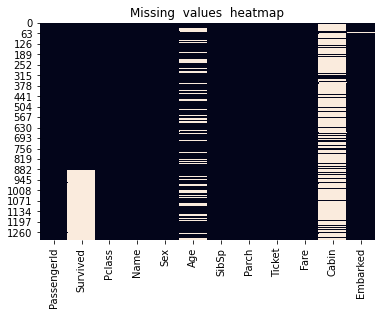

In [201]:
sns.heatmap(td.isnull(), cbar = False).set_title("Missing  values  heatmap")

In [202]:
td.nunique()#количество уникальных значений

PassengerId    1309
Survived          2
Pclass            3
Name           1307
Sex               2
Age              98
SibSp             7
Parch             8
Ticket          929
Fare            281
Cabin           186
Embarked          3
dtype: int64

Text(0.5, 1.0, 'Training Data - Percentage of people survived and Deceased')

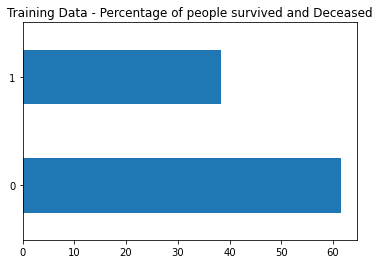

In [203]:
#  процент выживших
(trd.Survived.value_counts(normalize=True) * 100).plot.barh().set_title("Training Data - Percentage of people survived and Deceased")

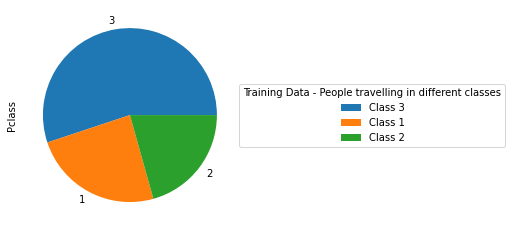

In [204]:
#  соотношение людей в разных классах
fig_pclass = trd.Pclass.value_counts().plot.pie().legend(labels=["Class 3","Class 1","Class 2"], loc='center right', bbox_to_anchor=(2.25, 0.5)).set_title("Training Data - People travelling in different classes")

Text(0.5, 1.0, 'Training Data - Percentage of people survived on the basis of class')

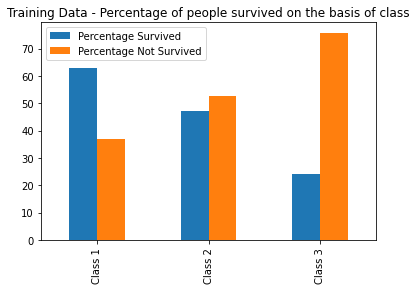

In [205]:
#  сколько в каждом классе выжило
pclass_1_survivor_distribution = round((trd[trd.Pclass == 1].Survived == 1).value_counts()[1]/len(trd[trd.Pclass == 1]) * 100, 2)
pclass_2_survivor_distribution = round((trd[trd.Pclass == 2].Survived == 1).value_counts()[1]/len(trd[trd.Pclass == 2]) * 100, 2)
pclass_3_survivor_distribution = round((trd[trd.Pclass == 3].Survived == 1).value_counts()[1]/len(trd[trd.Pclass == 3]) * 100, 2)
pclass_perc_df = pd.DataFrame(
    { "Percentage Survived":{"Class 1": pclass_1_survivor_distribution,"Class 2": pclass_2_survivor_distribution, "Class 3": pclass_3_survivor_distribution},  
     "Percentage Not Survived":{"Class 1": 100-pclass_1_survivor_distribution,"Class 2": 100-pclass_2_survivor_distribution, "Class 3": 100-pclass_3_survivor_distribution}})
pclass_perc_df.plot.bar().set_title("Training Data - Percentage of people survived on the basis of class")

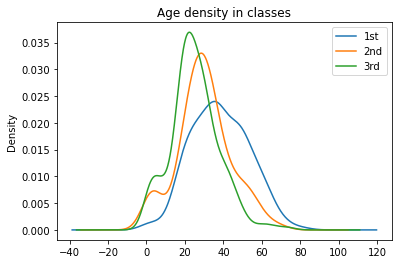

In [206]:
#  возраст в класса
for x in [1,2,3]:    ## for 3 classes
    trd.Age[trd.Pclass == x].plot(kind="kde")
plt.title("Age density in classes")
plt.legend(("1st","2nd","3rd"))

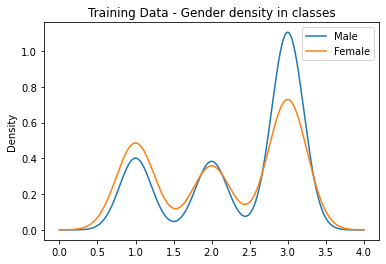

In [207]:
#пол в разных классах
for x in ["male","female"]:
    td.Pclass[td.Sex == x].plot(kind="kde")
plt.title("Training Data - Gender density in classes")
plt.legend(("Male","Female"))

In [208]:
#  процент выживших в классах
pclass_perc_df

,Percentage Survived,Percentage Not Survived
Class 1,62.96,37.04
Class 2,47.28,52.72
Class 3,24.24,75.76


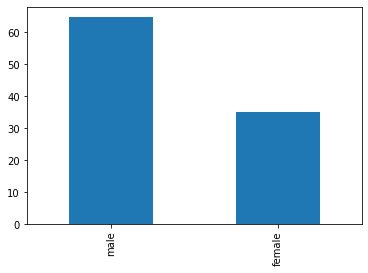

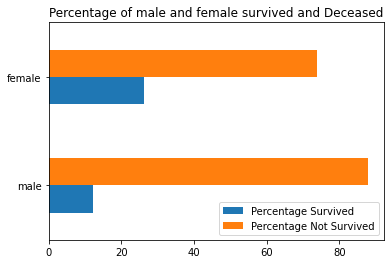

In [209]:
#  соотношение мужчин и женщин
fig_sex = (trd.Sex.value_counts(normalize = True) * 100).plot.bar()
male_pr = round((trd[trd.Sex == 'male'].Survived == 1).value_counts()[1]/len(trd.Sex) * 100, 2)
female_pr = round((trd[trd.Sex == 'female'].Survived == 1).value_counts()[1]/len(trd.Sex) * 100, 2)
sex_perc_df = pd.DataFrame(
    { "Percentage Survived":{"male": male_pr,"female": female_pr},  "Percentage Not Survived":{"male": 100-male_pr,"female": 100-female_pr}})
sex_perc_df.plot.barh().set_title("Percentage of male and female survived and Deceased")
fig_sex

In [210]:
#  статистика возраста
pd.DataFrame(td.Age.describe())

,Age
count,1046.000000
mean,29.881138
std,14.413493
min,0.170000
25%,21.000000
50%,28.000000
75%,39.000000
max,80.000000


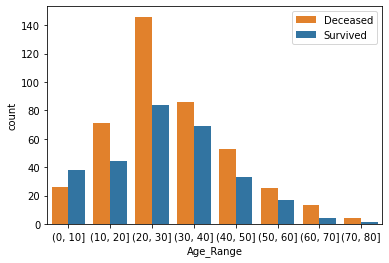

In [211]:
td['Age_Range'] = pd.cut(td.Age, [0, 10, 20, 30, 40, 50, 60,70,80])
sns.countplot(x = "Age_Range", hue = "Survived", data = td, palette=["C1", "C0"]).legend(labels = ["Deceased", "Survived"])

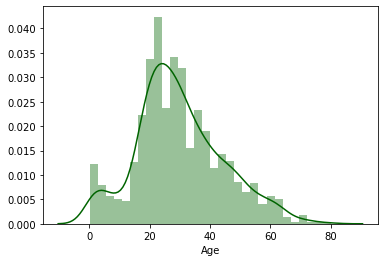

In [212]:
#  можем приблизительно заполнить пропущенные значения
sns.distplot(td['Age'].dropna(),color='darkgreen',bins=30)

In [213]:
#  статистика родственных связей
td.SibSp.describe()

count    1309.000000
mean        0.498854
std         1.041658
min         0.000000
25%         0.000000
50%         0.000000
75%         1.000000
max         8.000000
Name: SibSp, dtype: float64

Text(0.5, 1.0, 'Training Data - Number of siblings or spouses vs survival count')

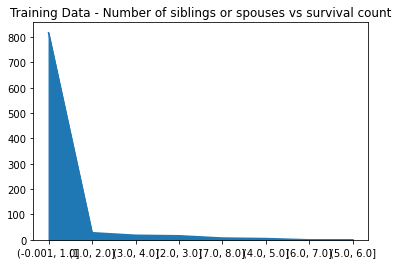

In [214]:
ss = pd.DataFrame()
ss['survived'] = trd.Survived
ss['sibling_spouse'] = pd.cut(trd.SibSp, [0, 1, 2, 3, 4, 5, 6,7,8], include_lowest = True)
(ss.sibling_spouse.value_counts()).plot.area().set_title("Training Data - Number of siblings or spouses vs survival count")

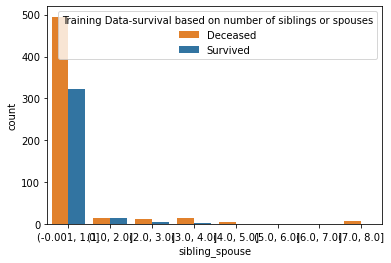

In [215]:
x = sns.countplot(x = "sibling_spouse", hue = "survived", data = ss, palette=["C1", "C0"]).legend(labels = ["Deceased", "Survived"])
x.set_title("Training Data-survival based on number of siblings or spouses")

In [216]:
#  статистика по количеству детей/родителей
pd.DataFrame(td.Parch.describe())

,Parch
count,1309.000000
mean,0.385027
std,0.865560
min,0.000000
25%,0.000000
50%,0.000000
75%,0.000000
max,9.000000


Text(0.5, 1.0, 'Training Data - Number of parents/children and survival density')

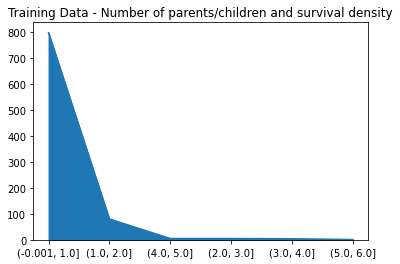

In [217]:
pc = pd.DataFrame()
pc['survived'] = trd.Survived
pc['parents_children'] = pd.cut(trd.Parch, [0, 1, 2, 3, 4, 5, 6], include_lowest = True)
(pc.parents_children.value_counts()).plot.area().set_title("Training Data - Number of parents/children and survival density")

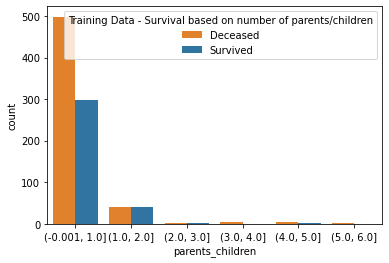

In [218]:
x = sns.countplot(x = "parents_children", hue = "survived", data = pc, palette=["C1", "C0"]).legend(labels = ["Deceased", "Survived"])
x.set_title("Training Data - Survival based on number of parents/children")

In [219]:
#  Мы создадим два новых столбца, столбец с именем family будет иметь сумму количества братьев и сестер / супруга и количества родителей / детей.
td['Family'] = td.Parch + td.SibSp
td['Is_Alone'] = td.Family == 0

In [220]:
#статистика тарифа, стоимости
td.Fare.describe()

count    1308.000000
mean       33.295479
std        51.758668
min         0.000000
25%         7.895800
50%        14.454200
75%        31.275000
max       512.329200
Name: Fare, dtype: float64

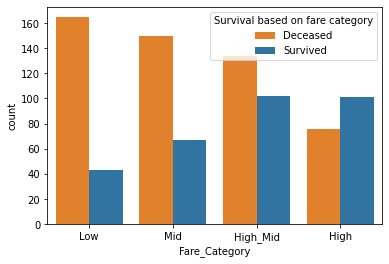

In [221]:
td['Fare_Category'] = pd.cut(td['Fare'], bins=[0,7.90,14.45,31.28,120], labels=['Low','Mid',
                                                                                      'High_Mid','High'])
x = sns.countplot(x = "Fare_Category", hue = "Survived", data = td, palette=["C1", "C0"]).legend(labels = ["Deceased", "Survived"])
x.set_title("Survival based on fare category")

Text(0.5, 1.0, 'Training Data - Survival based on embarking point.')

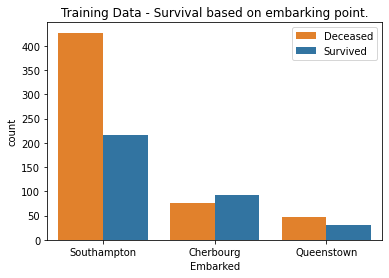

In [222]:
#    статистика выживаемости от пунка отправления
p = sns.countplot(x = "Embarked", hue = "Survived", data = trd, palette=["C1", "C0"])
p.set_xticklabels(["Southampton","Cherbourg","Queenstown"])
p.legend(labels = ["Deceased", "Survived"])
p.set_title("Training Data - Survival based on embarking point.")

In [223]:
#    подставляем пропущенные значения /пункт отправления
td.Embarked.fillna(td.Embarked.mode()[0], inplace = True)

In [224]:
#    подставляем пропущенные значения /возраст
td['Salutation'] = td.Name.apply(lambda name: name.split(',')[1].split('.')[0].strip())

td.Salutation.value_counts()

Mr              757
Miss            260
Mrs             197
Master           61
Dr                8
Rev               8
Col               4
Major             2
Ms                2
Mlle              2
Jonkheer          1
Sir               1
Capt              1
Mme               1
the Countess      1
Dona              1
Lady              1
Don               1
Name: Salutation, dtype: int64

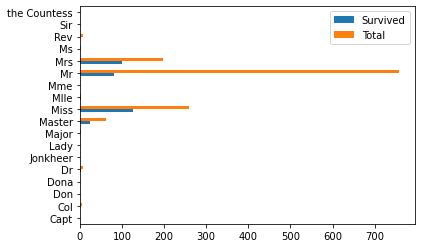

In [225]:
grp = td.groupby(['Sex', 'Pclass'])  #   Мы группируем названия и пол
td.Age = grp.Age.apply(lambda x: x.fillna(x.median())) #находим медиану всех категорий
#    If still any row remains 
#    заменяем пропущенные значения медианой этой категории
td.Age.fillna(td.Age.median, inplace = True)
sal_df = pd.DataFrame({
    "Survived":
    td[td.Survived == 1].Salutation.value_counts(),
    "Total":
        td.Salutation.value_counts()
})
s = sal_df.plot.barh()

In [226]:
td.Cabin = td.Cabin.fillna('NA') #     подставляем пропущенные значения/ кабина

In [227]:
from sklearn.preprocessing import LabelEncoder

td = pd.concat([td,pd.get_dummies(td.Cabin, prefix="Cabin"),pd.get_dummies(td.Age_Range, prefix="Age_Range"), pd.get_dummies(td.Embarked, prefix="Emb", drop_first = True), pd.get_dummies(td.Salutation, prefix="Title", drop_first = True),pd.get_dummies(td.Fare_Category, prefix="Fare", drop_first = True), pd.get_dummies(td.Pclass, prefix="Class", drop_first = True)], axis=1)
td['Sex'] = LabelEncoder().fit_transform(td['Sex'])
td['Is_Alone'] = LabelEncoder().fit_transform(td['Is_Alone'])
td.drop(['Pclass', 'Fare','Cabin', 'Fare_Category','Name','Salutation', 'Ticket','Embarked', 'Age_Range', 'SibSp', 'Parch', 'Age'], axis=1, inplace=True)

td.head(5)

,PassengerId,Survived,Sex,Family,Is_Alone,Cabin_A10,Cabin_A11,Cabin_A14,Cabin_A16,Cabin_A18,...,Title_Mrs,Title_Ms,Title_Rev,Title_Sir,Title_the Countess,Fare_Mid,Fare_High_Mid,Fare_High,Class_2,Class_3
0,1,0.0,1,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1
1,2,1.0,0,1,0,0,0,0,0,0,...,1,0,0,0,0,0,0,1,0,0
2,3,1.0,0,0,1,0,0,0,0,0,...,0,0,0,0,0,1,0,0,0,1
3,4,1.0,0,1,0,0,0,0,0,0,...,1,0,0,0,0,0,0,1,0,0
4,5,0.0,1,0,1,0,0,0,0,0,...,0,0,0,0,0,1,0,0,0,1


RF Accuracy: 83.24%
The cross validated score for Random forest is: 83.15


Text(0.5, 1.05, 'Confusion_matrix for RF')

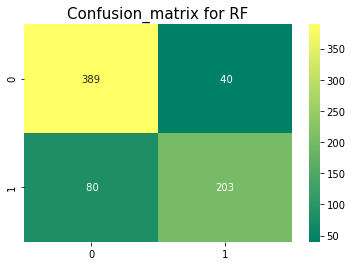

In [229]:
# Data to be predicted
X_to_be_predicted = td[td.Survived.isnull()]
X_to_be_predicted = X_to_be_predicted.drop(['Survived'], axis = 1)

#Training data
train_data = td
train_data = train_data.dropna()
feature_train = train_data['Survived']
label_train  = train_data.drop(['Survived'], axis = 1)
train_data.shape #891 x 28

#Random forest
clf = RandomForestClassifier(criterion='entropy',
n_estimators=700,
min_samples_split=10,
min_samples_leaf=1,
max_features='auto',
oob_score=True,
random_state=1,
n_jobs=-1)
x_train, x_test, y_train, y_test = train_test_split(label_train, feature_train, test_size=0.2)
clf.fit(x_train, np.ravel(y_train))
print("RF Accuracy: "+repr(round(clf.score(x_test, y_test) * 100, 2)) + "%")
result_rf=cross_val_score(clf,x_train,y_train,cv=10,scoring='accuracy')
print('The cross validated score for Random forest is:',round(result_rf.mean()*100,2))
y_pred = cross_val_predict(clf,x_train,y_train,cv=10)
sns.heatmap(confusion_matrix(y_train,y_pred),annot=True,fmt='3.0f',cmap="summer")
plt.title('Confusion_matrix for RF', y=1.05, size=15)

In [231]:
result = clf.predict(X_to_be_predicted)
submission = pd.DataFrame({'PassengerId':X_to_be_predicted.PassengerId,'Survived':result})
submission.Survived = submission.Survived.astype(int)
print(submission.shape)
filename = 'Titanic Predictions.csv'
submission.to_csv(filename,index=False)
print('Saved file: ' + filename)

(418, 2)
Saved file: Titanic Predictions.csv


In [232]:
submission.head(1309)

,PassengerId,Survived
891,892,0
892,893,0
893,894,0
894,895,0
895,896,1
...,...,...
1304,1305,0
1305,1306,1
1306,1307,0
1307,1308,0
